## Загрузим необходимые библиотеки

In [2]:
!pip3 install razdel

In [0]:
import joblib
import numpy as np
from collections import defaultdict
from tqdm.auto import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

from razdel import tokenize
from string import punctuation
punct = punctuation+'«»—…“”*–'

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

##  Загрузим данные

In [0]:
token2vec = joblib.load("/classification/token2vec.pkl")
train = pd.read_csv("/classification/train.tsv", sep="\t")
test = pd.read_csv("/classification/test.tsv", sep="\t")

In [0]:
word2index = defaultdict(int)
vectors = []

word2index['PAD'] = 0
vectors.append(np.zeros((1, 200))) 
    
for word, vec in token2vec.items():
    word2index[word] = len(word2index)
    vec = np.expand_dims(vec, 0)
    vectors.append(vec)
    
vectors = np.concatenate(vectors)

In [0]:
def tag(x):
    return 0 if x==3 else x 
    
# теги для 3-классовой классификации
test["3_class_tag"] = test.tag.apply(tag)

In [0]:
def tag(x):
    return 0 if (x==3 or x==0) else x 

train = train[train.source != 'binary-tag-edit-dist']
# теги для 3-классовой классификации
train["3_class_tag"] = train.tag.apply(tag)

In [12]:
train.groupby("3_class_tag").count()/len(train) # [0.44, 0.31, 0.25]

,binary_tag,pair_id,prev_query,query,source,tag
3_class_tag,,,,,,
0,0.435996,0.435996,0.435996,0.435996,0.435996,0.435996
1,0.314044,0.314044,0.314044,0.314044,0.314044,0.314044
2,0.249960,0.249960,0.249960,0.249960,0.249960,0.249960


In [13]:
len(train)

6273

## Подстраиваем данные под формат нейросети

In [0]:
class Data(Dataset):
    
    def __init__(self, 
                 x1_data, 
                 x2_data, 
                 y_data, 
                 word2index, 
                 pad_token='PAD',
                 sequence_length=10, 
                 verbose=True):
        
        super().__init__()
        
        self.y_data = y_data
        
        self.word2index = word2index
        self.sequence_length = sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.x1 = self.load(x1_data, verbose=verbose)
        self.x2 = self.load(x2_data, verbose=verbose)
        
    @staticmethod
    def process_query(query):
        line = query.strip()
        tokens = list(tokenize(line))
        tokens = [_.text.lower() for _ in tokens]         
        tokens = [i for i in tokens if i not in punct]
        return tokens
        
    def load(self, data, verbose=True):
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        x = []
        for query in data_iterator:
            words = self.process_query(query)
            indexed_words = self.indexing(words)
            x.append(indexed_words)
        return x
    
    def indexing(self, tokenized_query):
        query_indices = []
        for word in tokenized_query:
            query_indices.append(self.word2index[word])
        return query_indices
            
    
    def padding(self, sequence):
        if len(sequence) > self.sequence_length:
            sequence = sequence[: self.sequence_length]
        elif len(sequence) < self.sequence_length:
            sequence += [self.pad_index for i in range(self.sequence_length-len(sequence))]
        return sequence
    
    def __len__(self):
        return len(self.x1)
    
    def __getitem__(self, idx):
        x1 = self.x1[idx]
        x1 = self.padding(x1)
        x1 = torch.Tensor(x1).long()
        
        x2 = self.x2[idx]
        x2 = self.padding(x2)
        x2 = torch.Tensor(x2).long()
        
        y = self.y_data[idx]
        
        return x1, x2, y

In [15]:
# делим на train и test
train = train.sample(frac=1)
test = test.sample(frac=1)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
train_data = Data(train["prev_query"], 
                   train["query"], 
                   train["3_class_tag"], 
                   word2index)
test_data = Data(test["prev_query"], 
                   test["query"], 
                   test["3_class_tag"], 
                   word2index)

## Строим класс модели Biattn+Orthogonal+CNN+Linear

In [0]:
# orthogonal
class ClassifierWithAttention(torch.nn.Module):
    
    def __init__(self, 
               embedding_tensor, 
               n_classes=3, 
               sequence_len=10, 
               rnn_model='LSTM', 
               hidden_size=300,  
               batch_first=True, 
               kernel_sizes=[2,3],
               keep_proba=0.5,
            cnn_out=100, 
            ):
  
        super(ClassifierWithAttention, self).__init__()
  
        # embeddings
        self.word_embeddings = torch.nn.Embedding.from_pretrained(embedding_tensor, padding_idx=0)
        self.word_embeddings.weight.requires_grad = False
        self.embed_size = embedding_tensor.shape[1]

        self.dropout = torch.nn.Dropout(p=keep_proba)

        self.emb_batchnorm = torch.nn.BatchNorm1d(sequence_len)

        # BiLSTM
        if rnn_model == 'LSTM':
            self.LSTM = torch.nn.LSTM(input_size=self.embed_size, 
                                      hidden_size=self.embed_size, 
                                      batch_first=True)


        # Attention
        self.key1 = torch.nn.Linear(in_features=self.embed_size, out_features=hidden_size) # encoder hidden
        self.query1 = torch.nn.Linear(in_features=self.embed_size, out_features=hidden_size) # decoder hidden
        self.value1 = torch.nn.Linear(in_features=self.embed_size, out_features=hidden_size) # encoder hidden

        self.key2 = torch.nn.Linear(in_features=self.embed_size, out_features=hidden_size) # encoder hidden
        self.query2 = torch.nn.Linear(in_features=self.embed_size, out_features=hidden_size) # decoder hidden
        self.value2 = torch.nn.Linear(in_features=self.embed_size, out_features=hidden_size) # encoder hidden

        self.CNN_layer_1 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels=hidden_size*2, 
                out_channels=cnn_out, 
                kernel_size=kernel_sizes[0]
            ),
            torch.nn.BatchNorm1d(cnn_out),
            torch.nn.ReLU(), 
            torch.nn.MaxPool1d(kernel_size=sequence_len - kernel_sizes[0] + 1),
            torch.nn.Dropout(p=keep_proba),
        ) 
    
        self.CNN_layer_2 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels=hidden_size*2, 
                out_channels=cnn_out, 
                kernel_size=kernel_sizes[1]),
            torch.nn.BatchNorm1d(cnn_out),
            torch.nn.ReLU(), 
            torch.nn.MaxPool1d(kernel_size=sequence_len - kernel_sizes[1] + 1),
            torch.nn.Dropout(p=keep_proba),
        )

        self.CNN_layer_3 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels=hidden_size*2, 
                out_channels=cnn_out, 
                kernel_size=kernel_sizes[0]
            ),
            torch.nn.BatchNorm1d(cnn_out),
            torch.nn.ReLU(), 
            torch.nn.MaxPool1d(kernel_size=sequence_len - kernel_sizes[0] + 1),
            torch.nn.Dropout(p=keep_proba),
        ) 
    
        self.CNN_layer_4 = torch.nn.Sequential(
            torch.nn.Conv1d(
                in_channels=hidden_size*2, 
                out_channels=cnn_out, 
                kernel_size=kernel_sizes[1]),
            torch.nn.BatchNorm1d(cnn_out),
            torch.nn.ReLU(), 
            torch.nn.MaxPool1d(kernel_size=sequence_len - kernel_sizes[1] + 1),
            torch.nn.Dropout(p=keep_proba),
        )
        
        self.linear1 = torch.nn.Linear(cnn_out*4, n_classes)
        #self.relu = torch.nn.ReLU()
        #self.linear2 = torch.nn.Linear(hidden_size, n_classes)
  
    def apply_attention(self, key, query, value):
        attention_scores = torch.bmm(query, key.transpose(1, 2))
        attention_distribution = torch.nn.functional.softmax(attention_scores, dim=2)
        atnn = torch.bmm(attention_distribution, value)        
        return atnn

    def linear_decomposition(self, attn_vector, query):
        cosine_sims = torch.nn.functional.cosine_similarity(attn_vector, query, dim=-1)
        alpha = cosine_sims.unsqueeze(-1)
        positives = alpha * query
        negatives = (1.0 - alpha) * query
        return positives, negatives

    def orthogonal_decomposition(self, attn_vector, query):
        alpha = ((query * attn_vector).sum(-1) / (attn_vector*attn_vector).sum(-1)).unsqueeze(-1)
        parallel = alpha * attn_vector
        orthogonal = query - parallel
        return parallel, orthogonal
    
    def forward(self, x1, x2):

        x1_embed = self.word_embeddings(x1)
        x2_embed = self.word_embeddings(x2)

        #out_rnn_1, _ = self.LSTM(x1_embed)
        #out_rnn_2, _ = self.LSTM(x2_embed)

        key1 = self.key1(x1_embed)
        query1 = self.query1(x2_embed)
        value1 = self.value1(x1_embed)

        key2 = self.key2(x2_embed)
        query2 = self.query2(x1_embed)
        value2 = self.value2(x2_embed)

        attn_forward = self.apply_attention(key1, query1, value1)
        positives, negatives = self.orthogonal_decomposition(attn_forward, query1)
        res_forward = torch.cat([positives, negatives], dim=-1).transpose(1, 2)
        res_forward = self.dropout(res_forward)

        attn_backward = self.apply_attention(key2, query2, value2)
        positives, negatives = self.orthogonal_decomposition(attn_backward, query2)
        res_backward = torch.cat([positives, negatives], dim=-1).transpose(1, 2)
        res_backward = self.dropout(res_backward)

        out_cnn_1_f = self.CNN_layer_1(res_forward)
        out_cnn_2_f = self.CNN_layer_2(res_forward)

        out_cnn_1_b = self.CNN_layer_3(res_backward)
        out_cnn_2_b = self.CNN_layer_4(res_backward)

        out_cnn = torch.cat([out_cnn_1_f.squeeze(2), 
                             out_cnn_2_f.squeeze(2),
                             out_cnn_1_b.squeeze(2),
                             out_cnn_2_b.squeeze(2)
                            ],
                            dim=1)

        pred = self.linear1(out_cnn)

        return pred

## Обучение

In [0]:
import torch.optim as optim

train_loader = DataLoader(train_data, batch_size=32, drop_last=True)
test_loader = DataLoader(test_data, batch_size=32, drop_last=True)

epochs = 10

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

vectors = torch.FloatTensor(vectors)
model = ClassifierWithAttention(embedding_tensor=vectors).to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer.param_groups[0]["initial_lr"] = 0.00005
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.8) 

iteration_losses = []
epoch_train_losses = []
epoch_test_losses = []
accuracies = []
f_scores = []

In [0]:
import copy

In [69]:
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm

best_test_loss = 1.5
best_f_score = 0.2

for n_epoch in range(epochs):
    model.train()
        
    train_losses = []
    test_losses = []
    test_targets = []
    test_preds = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

    for x1,x2,y in train_loader:
        optimizer.zero_grad()
        pred = model.forward(x1.to(device), x2.to(device))            
        loss = criterion(pred, y.long().to(device))
        loss.backward()
        optimizer.step() 
        
        iteration_losses.append(loss.item())
        train_losses.append(loss.item())
        progress_bar.set_postfix(loss=np.mean(iteration_losses[-50:]))
        progress_bar.update(x1.shape[0])
        
    progress_bar.close()
    epoch_train_losses.append(np.mean(train_losses))
  
    model.eval()
    for x1_test, x2_test, y_test in test_loader:
        with torch.no_grad():
            pred = model.forward(x1_test.to(device), x2_test.to(device))
            test_preds.append(pred.cpu()) 
            test_targets.append(y_test.long())
            loss = criterion(pred, y_test.long().to(device))
            test_losses.append(loss.item()) 
        
    mean_test_loss = np.mean(test_losses)
    epoch_test_losses.append(mean_test_loss)
    
    print('Training: train loss = {:.3f}, test loss = {:.3f} '.format(np.mean(train_losses), mean_test_loss))
    print("Evaluating...")
    
    test_preds_cat = torch.cat(test_preds, dim=0)
    test_preds_argmax = torch.argmax(test_preds_cat, dim=1)
    test_targets = torch.cat(test_targets, dim=0)  

    accuracy = accuracy_score(test_targets, test_preds_argmax)
    f_score = f1_score(test_targets, test_preds_argmax, average='weighted')
    accuracies.append(accuracy)
    f_scores.append(f_score)
    print('Accuracy = {:.3f}, f1-score = {:.3f}'.format(accuracy, f_score))
    scheduler.step()
    if f_score > best_f_score:
        best_f_score = f_score
        best_model = copy.deepcopy(model)
    # else:
    #     print('Early stopping')
    #     break


Training: train loss = 0.975, test loss = 0.914 
Evaluating...
Accuracy = 0.600, f1-score = 0.600



Training: train loss = 0.664, test loss = 0.848 
Evaluating...
Accuracy = 0.646, f1-score = 0.645



Training: train loss = 0.398, test loss = 1.139 
Evaluating...
Accuracy = 0.638, f1-score = 0.634



Training: train loss = 0.254, test loss = 1.422 
Evaluating...
Accuracy = 0.606, f1-score = 0.597



Training: train loss = 0.162, test loss = 1.390 
Evaluating...
Accuracy = 0.643, f1-score = 0.640



Training: train loss = 0.129, test loss = 1.508 
Evaluating...
Accuracy = 0.646, f1-score = 0.644



Training: train loss = 0.081, test loss = 1.650 
Evaluating...
Accuracy = 0.640, f1-score = 0.637



Training: train loss = 0.051, test loss = 1.651 
Evaluating...
Accuracy = 0.656, f1-score = 0.655



Training: train loss = 0.040, test loss = 1.665 
Evaluating...
Accuracy = 0.661, f1-score = 0.660



Training: train loss = 0.028, test loss = 1.880 
Evaluating...
Accuracy = 0.629, f1-score = 0.626


In [0]:
test_preds = []
test_targets = []

best_model.eval()
for x1_test, x2_test, y_test in test_loader:
    with torch.no_grad():
        pred = best_model.forward(x1_test.to(device), x2_test.to(device))
        test_preds.append(pred.cpu()) 
        test_targets.append(y_test.long())
        loss = criterion(pred, y.long().to(device))
        test_losses.append(loss.item()) 

test_preds_cat = torch.cat(test_preds, dim=0)
test_preds_argmax = torch.argmax(test_preds_cat, dim=1)
# test_preds_argmax = [0 if i <= 0.0 else 1 for i in test_preds_cat]
test_targets = torch.cat(test_targets, dim=0)  


In [75]:
df = test[:672]
print(classification_report(df["3_class_tag"], test_preds_argmax))

              precision    recall  f1-score   support

           0       0.63      0.77      0.69       201
           1       0.71      0.62      0.66       306
           2       0.62      0.60      0.61       165

    accuracy                           0.66       672
   macro avg       0.65      0.66      0.66       672
weighted avg       0.67      0.66      0.66       672



In [76]:
print(f1_score(df["3_class_tag"], test_preds_argmax, average="micro"))

0.6607142857142857


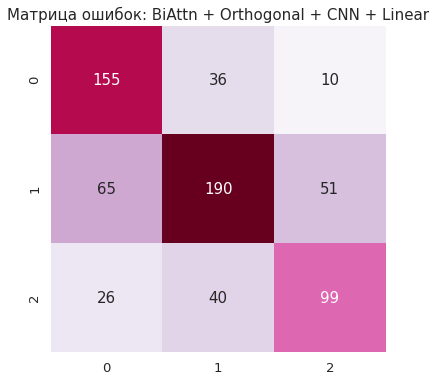

              precision    recall  f1-score   support

           0       0.63      0.77      0.69       201
           1       0.71      0.62      0.66       306
           2       0.62      0.60      0.61       165

    accuracy                           0.66       672
   macro avg       0.65      0.66      0.66       672
weighted avg       0.67      0.66      0.66       672



In [77]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

m = confusion_matrix(df["3_class_tag"], test_preds_argmax)
sns.set(font_scale=1.2)
plt.figure(figsize = (6,6))
sns.heatmap(data=m, annot=True, fmt="d", cbar=False, 
            xticklabels=[0,1, 2], 
            yticklabels=[0,1,2], 
            cmap="PuRd",
           annot_kws={"size": 15})
plt.title("Матрица ошибок: BiAttn + Orthogonal + CNN + Linear", fontsize=15)
plt.show()

# результаты могут незначительно отличаться от результатов 
# из диплома из-за рандомной инициилизации весов
print(classification_report(df["3_class_tag"], test_preds_argmax))